In [12]:
# Testing Pacman
import postprocess as pp
import plots as plots


In [13]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes

from pathlib import Path 

## Stability of a discrete system

In [14]:
# Run the simulation:

# !../practice/discrete-atk.py -N 2
# !../practice/discrete-atk.py -N 3

## Postprocessing

In [15]:
# Postprocessing capabilities

def plot_energy_spectrum(_data, inset_xbounds=[.5, 1.1]):
    """docstring for plot_energy_spectrum"""

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))
    
    _asd = np.array([step["lambda_0"] for step in _data["cone_data"]])
    _lambda_0 = [np.nan if type(a) is list else a for a in _asd ]

    axis.plot(_data.load, _data.fracture_energy, lw=7, label = 'damage', marker='o')
    axis.plot(_data.load, _data.elastic_energy, lw=7, label = 'elastic')
    _total = _data.fracture_energy + _data.elastic_energy
    axis.plot(_data.load, _total, lw=5, label = 'total', zorder=.1)
    # plt.axvline(__tc, c='k')
    # plt.axvline(_tc, c='k', lw=1)
    axis.legend()
    axis.set_xlabel('load', fontsize=24, color='k')
    axis.set_ylabel('Energy', fontsize=24, color='k')
    plt.tight_layout()

    _ax = plt.gca()

    zax = inset_axes(_ax,  width='40%', height='40%', loc=3,
        bbox_to_anchor=(.1,1-.6,1,1), bbox_transform=_ax.transAxes)
    # plot again (PLOT AGAIN) the same stuff as before in the new axes
    zax.plot(_data.load, _lambda_0, marker="o", alpha = .7, ls='', ms=10)
    zax.axhline(0, c='grey')
    zax.set_title('K-spectrum')

    zax.set_xlim((inset_xbounds[0], inset_xbounds[1])) ; 
    _ts_i = np.where(np.array(_lambda_0) < 0)[0][0]
    _ts = _data.load[_ts_i]
    _tr = np.where(np.abs(np.diff(_data.elastic_energy))>.02)

    rectpatch, connects= _ax.indicate_inset_zoom(zax, lw=2, ec='none', alpha=.7, capstyle='butt', edgecolor='grey')
    zax.set_facecolor((1.0, 1., 1.))

    connects[0].set_visible(True)
    connects[1].set_visible(False)
    connects[2].set_visible(True)
    connects[3].set_visible(True)

    _ax.set_xticks([0., _data.load[_tr[0]].values[0], 1, _ts], ["$$0=t_c$$", "$$t_?$$", "1", "$$t_s$$"])
    zax.set_xticks([1, _ts], ["$$1$$", "$$t_s$$"])
    zax.set_yticks([0], ["$$0$$"])
    _ax.set_yticks([0], ["$$0$$"])
    _ax.set_title("Evolution of a brittle bar with an elastic phase")

    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)

    return figure, (_ax, zax)


def _plot_min_sigmaKappa(data, axis=None, params=None):
    """docstring for _plot_min_sigmaKappa"""
     
    if axis is None:
        figure, axis = plt.subplots(1, 1, figsize=(12, 9))
    
    _asd = np.array([step["lambda_0"] for step in data["cone_data"]])
    _lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
    _stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]


    if params is None:
        _params = matpar
    else:
        _params = params
        _tc = _critical_load(params)
    # print(_tc)
    
    _ax = axis
    # [0 if x==3 for x in _asd]
    _ax.plot(data.load, _lambda_0, marker='o', ls='', label=f"N={params['N']}")
    _ax.axhline(0, c='k')
    # _ax.ylim([0, 1.])
    _ax.set_xlim([0, _k])

    _ax.axvline(_tc, c='k', lw=1)
    # _ax.axvline(_tc.subs(_params), c='k', lw=1)
    _ax.axvline(_k, c='k', lw=1)

    _ax.set_xticks([_tc, _k], ['$t_c$', '$k$'])
    # _ax.set_xticks([_tc.subs(_params), _k], ['$t_c$', '$k$'])
    # _ax.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.2)
    _ax.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.2)
    _ax.set_title('Inf of the K-spectrum and stability')

    _ax.legend(loc=2)

    return _ax


def _postprocess_stability(data):
    """docstring for _postprocess_stability"""
    figure, axis = plt.subplots(2, 2, figsize=(12, 9))


    # axis[0, 0].plot(X, Y1)
    _ax = axis[0, 0]
    _ax.plot(data.load, data.fracture_energy, label = 'damage')
    _ax.plot(data.load, data.elastic_energy, label = 'elastic')
    _total = data.fracture_energy + data.elastic_energy
    _ax.plot(data.load, _total, label = 'total')
    _ax.legend()
    _ax.set_xlabel('load')
    _ax.set_ylabel('Energy')

    _ax = axis[0, 1]

    _ax.plot(data.load, data.F, label = 'stress')
    _ax.legend()
    _ax.set_xlabel('load')
    _ax.set_ylabel('stress')

    _ax = axis[1, 0]

    for k in range(model_parameters["N"]+1):
        _ax.plot(data.load, [u[k] for u in data.u_t], label=f'$u_{k}$', c='C1')
    # _ax.plot(data.load, 1/_mu*data.load/2, label=f'$u^*$', ls='dotted', lw=4)

    _ax.legend()
    _ax.set_title("$u$")

    _ax2 = _ax.twinx()

    for k in range(model_parameters["N"]):
        _ax2.plot(data.load, [a[k] for a in data.alpha_t], label=f'$\\alpha_{k}$', lw=3, c='C2')

    _ax2.set_title("$\\alpha$")
    _ax2.legend(loc=4)
    _ax2.axhline(1, c='k')

    _ax = axis[1, 1]
    # params.get("loading")
    # 
    s0 = []
    
    # _dt = (params.get("loading").get("max") - params.get("loading").get("min")) /params.get("loading").get("steps")
    _dt = data.load[1]-data.load[0]

    for i, t in enumerate(data.get("load")):
        s0.append(np.trapz(data.get("rate_12_norm")[0:i], data.get("load")[0:i])/_dt)
        
    s = data.get("load") + s0

    _ax.plot(data.get("load"), s, marker = 'o', label='s')
    _ax.plot(data.get("load"), s0, marker = 'o', label='s0')
    _ax.set_title("Rate norms")
    _ax2 = _ax.twinx()
    _ax2.plot(data.get("load"), data.get("fracture_energy"), marker = 's', c='k', label='fra')
    _ax2.set_ylabel("Energies")
    _ax.legend()
    
    for _ax in axis.reshape(-1):
        _ax.axvline(_tc.subs(matpar), c='k', lw=1)

    plt.show()

def _postprocess_stability2(data):

    """docstring for _postprocess_stability"""
    figure, axis = plt.subplots(2, 2, figsize=(12, 9))
    
    _asd = np.array([step["lambda_0"] for step in data["cone_data"]])
    _lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
    _stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]

    _ax = axis[0, 0]
    
    for i in range(len(data.cone_data)):
        _ax.plot(data.cone_data[i]['error_x_L2'], label=f'step {i}')
    _ax.semilogy()
    # _ax.legend()
    _ax.set_xlabel('iterations')
    _ax.set_ylabel('$||\Delta x_k||_{L^2}$')

    _ax = axis[0, 1]

    _ax.scatter(data.load, _lambda_0, c=_stab_cnd, cmap='RdYlGn_r', alpha=.8)
    _ax.set_xlim([0, _k])
    _ax.set_ylim([-1, 1])
    _ax.axhline(0, c='k')

    _ax.set_title('Stability, minimum K-eigen')
    _ax.legend()
    _ax.set_xlabel('load')
    _ax.set_ylabel('$min \\sigma_K$')

    _ax = axis[1, 0]
    # [0 if x==3 for x in _asd]
    _ax.plot(data.load, _lambda_0, marker='o', ls='')
    _ax.axhline(0, c='k')
    # _ax.ylim([0, 1.])
    _ax.set_xlim([0, _k])

    _ax.axvline(_tc.subs(matpar), c='k', lw=1)
    _ax.axvline(_k, c='k', lw=1)

    _ax.set_xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
    _ax.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
    _ax.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.5)
    _ax.set_title('Minimum eigenvalue and stability')

    _ax.legend()

    _ax = axis[1, 1]
    _ax.plot(data.load, data.F, label = 'stress')
    _ax.fill_between(data.load, 0, .1, where=_stab_cnd,color='red', alpha=0.5)
    _ax.fill_between(data.load, 0, .1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
    _ax.legend()

    _ax.axvline(_tc.subs(matpar), c='k', lw=1)
    _ax.axvline(_k, c='k', lw=1)
    _ax.axvline(_k/2, c='k', lw=1)

    _ax.set_xticks([_tc.subs(matpar), _k/2, _k], ['$t_c$', '$k/2$', '$k$'])
    _ax.set_title(f'N={_N}, k={_k}')


    for _ax in axis.reshape(-1):
        _ax.axvline(_tc.subs(matpar), c='k', lw=1)

    plt.show()

_stab_cnd = lambda data: [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]

def plotSpaceVsCone(data):
    _stab_cnd = lambda data: [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]

    """docstring for plotSpaceVsCone"""
    figure, axis = plt.subplots(1, 1)
    __lambda_0 = [e[0] for e in data['eigs']]

    axis.scatter(data.load, _lambda_0, c=_stab_cnd(data), cmap='RdYlGn_r', alpha=.8, marker="*", s=200, label='cone')
    axis.scatter(data.load, __lambda_0, c=_stab_cnd(data), cmap='RdYlGn_r', alpha=.8, label='space')
    axis.axhline(0., c='k')
    axis.set_title('Min eig in cone vs. space')
    axis.legend()


In [188]:
def _inf_Kspectrum(_data):
    """docstring for _spectrum"""
    _asd = np.array([step["lambda_0"] for step in _data["cone_data"]])
    _lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
    return _lambda_0

def get_stability_load(_lambda_0, data):
    """docstring for get_stability_load"""
    # _ts_i = np.where(np.array(_lambda_0) < 0)[0][0]
    # _ts = data.load[_ts_i]

    _ts_i = np.where(np.abs(np.diff(_lambda_0))>.0001)[0][0]
    _ts = data.load[_ts_i]
    return _ts

def get_crack_load(_data):
    """docstring for get_crack_load"""
    return np.where(np.abs(np.diff(_data.elastic_energy))>.02)


## N=2

In [5]:
# experiment = '../../practice/output/discrete-atk-N2'
experiment = '../../test/output/discrete-atk-N2'
params, data, signature = pp.load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get(
    "w1"), model_parameters.get("k"), model_parameters["N"]


In [6]:
_postprocess_stability(data)
_postprocess_stability2(data)

NameError: name '_tc' is not defined

FileNotFoundError: missing font metrics file: cmr17

<Figure size 864x648 with 6 Axes>

$$
E(u):=\frac{1}{2} N\mu\sum_{i=1}^N a_k(\alpha_i)(u_{i}-u_{i-1})^2 + \frac{w_1}{N} \sum_{i=1}^N w(\alpha_i)
$$

$$
w(\alpha):= \alpha, \qquad a_k(\alpha):= \frac{1-\alpha}{\alpha(k-1)+1}
$$

## Analytic solution

In [7]:
## Simple Analytic 
α, α1, α2, e1, e2 = sp.symbols('α α1 α2 e1 e2')
u1, u2 = sp.symbols('u1 u2')
K1, K2 = sp.symbols('K1 K2', positive=True)
s1, s2 = sp.symbols('s1 s2', positive=True)
μ, N = sp.symbols('μ N', positive=True)
w1 = sp.symbols('w1', positive=True)
t = sp.Symbol('t', positive=True)
k = sp.Symbol('k', positive=True)

# _N = 2

K = lambda α: (1-α)/(1+(k-1)*α)
s = lambda α: 1/K(α)

U = 1/2*μ*(K1*u1**2 + K2*(t-u1)**2)

S = w1*(α1 + α2) / N**2

sol_u = sp.solve(U.diff(u1), u1)



In [8]:
U

0.5*μ*(K1*u1**2 + K2*(t - u1)**2)

In [9]:
sp.latex(U)

'0.5 μ \\left(K_{1} u_{1}^{2} + K_{2} \\left(t - u_{1}\\right)^{2}\\right)'

In [10]:
sp.simplify(sol_u[0])

K2*t/(K1 + K2)

In [11]:
sp.simplify(sol_u[0]).subs({K1: 1/s(α), K2: 1/s(α)})

t/2

In [12]:
E=U.subs(u1, sol_u[0]).simplify()
E

0.5*K1*K2*t**2*μ/(K1 + K2)

In [13]:
E.subs({K1: 1/s(α), K2: 1/s(α)})

0.25*t**2*μ*(1 - α)/(α*(k - 1) + 1)

In [14]:
E.subs({K1: 1/s1, K2: 1/s2}).simplify()

0.5*t**2*μ/(s1 + s2)

In [15]:
_E = E.subs({K1: 1/s(α), K2: 1/s(α)})
_E

0.25*t**2*μ*(1 - α)/(α*(k - 1) + 1)

In [16]:
F = (E+S)
# .subs({K1: 1/s(α), K2: 1/s(α)}).subs({})
F = (E+S).subs({K1: 1/s1, K2: 1/s2})

F

0.5*t**2*μ/(s1*s2*(1/s2 + 1/s1)) + w1*(α1 + α2)/N**2

In [17]:
# F.subs({K1: 1/s1, K2: 1/s2}).simplify()

In [18]:
F = (E+S).subs({K1: 1/s(α), K2: 1/s(α), α1: α, α2: α})

Fa = F.diff(α).simplify()
Fa

-0.25*k*t**2*μ/(k*α - α + 1)**2 + 2*w1/N**2

In [19]:
Fa.subs({α: 0})

-0.25*k*t**2*μ + 2*w1/N**2

In [22]:
sp.solve(Fa.subs(matpar).subs({α: 0}), t)

NameError: name 'matpar' is not defined

In [ ]:
Fa.subs({α: 0})

-0.25*k*t**2*μ + 2*w1/N**2

In [23]:
sp.solve(-1./4.*k*t*μ + 2*w1/N**2, t)[0]

8.0*w1/(N**2*k*μ)

In [24]:
sp.latex(sp.solve(-1./4.*k*t*μ + 2*w1/N**2, t)[0])

'\\frac{8.0 w_{1}}{N^{2} k μ}'

In [25]:
sp.solve(Fa, t)[1].subs({α: 0})

2.82842712474619*sqrt(w1)/(N*sqrt(k)*sqrt(μ))

In [26]:
sp.lambdify((α, t), F, 'numpy')

<function _lambdifygenerated(α, t)>

In [27]:
F

0.25*t**2*μ*(1 - α)/(α*(k - 1) + 1) + 2*w1*α/N**2

In [28]:

matpar = {k: _k, w1: _w1, N: _N, μ: _mu}



In [29]:
_F = sp.lambdify((α, t), F.subs(matpar), 'numpy')
_F(0, 1)

0.25

In [30]:
s(α).diff(α, 2)

2*(k - 1 - (α*(k - 1) + 1)/(α - 1))/(α - 1)**2

In [31]:

α = sp.symbols('α')
t, N, k = sp.symbols('t N k')
τ = sp.Symbol('τ', positive=True)

_α0 = (τ-1)/(k-1)
_Ηeye = t**2/(N*s(α))**2 * ((s(α).diff(α))**2 / (N*s(α)) - 1./2.*s(α).diff(α, 2)) 
_Ηout = t**2*(s(α).diff(α))**2 / (N*s(α))**3


# Ηeye = sp.lambdify(τ, _Ηeye.subs(matpar), 'numpy')
# Ηout = sp.lambdify(τ, _Ηout.subs(matpar), 'numpy')


In [32]:
_Ηeye.simplify()

t**2*(α*(k - 1) + (1 - k)*(α - 1) + 1)*(1.0*N*(α*(k - 1) + 1) - α*(k - 1) - (1 - k)*(α - 1) - 1)/(N**3*(α - 1)*(α*(k - 1) + 1)**3)

In [33]:
_Ηout

t**2*(1 - α)**3*((k - 1)/(1 - α) + (α*(k - 1) + 1)/(1 - α)**2)**2/(N**3*(α*(k - 1) + 1)**3)

In [34]:
_Ηeye.subs({α: _α0}).simplify()

1.0*k*t**2*(-N*k*τ + N*τ + k**2 - k)/(N**3*τ**3*(k - τ))

In [35]:
_Ηeye.subs({α: _α0, N: 2}).simplify()

0.125*k*t**2*(1.0*k**2 - 2.0*k*τ - 1.0*k + 2.0*τ)/(τ**3*(k - τ))

In [36]:
a_atk(α).subs({α: _α0})

NameError: name 'a_atk' is not defined

In [37]:
s(α).subs({α: _α0})

τ/(1 - (τ - 1)/(k - 1))

In [38]:
s(α).diff(α).subs({α: _α0}).simplify()

k*(k - 1)**2/(k - τ)**2

In [39]:
s(α).diff(α, 2).subs({α: _α0}).simplify()

2*(k - 1)**2*(τ*(k - 1) - (1 - k)*(k - τ))/(k - τ)**3

Stability condition

$$
 \frac{s'(\alpha_0)^2}{Ns_0} - \frac{s''(\alpha_0)}{2}<0
$$

In [40]:
s(α).diff(α)**2 / (N*s(α)) - s(α).diff(α, 2)/2

-(k - 1 - (α*(k - 1) + 1)/(α - 1))/(α - 1)**2 + (1 - α)*((k - 1)/(1 - α) + (α*(k - 1) + 1)/(1 - α)**2)**2/(N*(α*(k - 1) + 1))

On the homogeneous solution

N= 2

$$
Ηeye =\frac{k-1}{k-τ}\frac{k-2τ}{τ}
$$
$$
Ηout = \frac{k-1}{k-τ}\frac{k}{τ}
$$

In [41]:
(s(α).diff(α)**2 / (N*s(α)) - s(α).diff(α, 2)/2 ).subs({α: _α0})

-(k - τ/(-1 + (τ - 1)/(k - 1)) - 1)/(-1 + (τ - 1)/(k - 1))**2 + (1 - (τ - 1)/(k - 1))*(τ/(1 - (τ - 1)/(k - 1))**2 + (k - 1)/(1 - (τ - 1)/(k - 1)))**2/(N*τ)

In [42]:
_hstability = ( s(α).diff(α)**2 / (N*s(α)) - s(α).diff(α, 2)/2 ).subs({α: _α0})
hstability = sp.lambdify((τ, N, k), _hstability, 'numpy')


In [43]:
plt.plot(data.load, hstability(data.load, 2, 4))

FileNotFoundError: missing font metrics file: cmr17

<Figure size 432x288 with 1 Axes>

In [119]:
data.load;

## Verification

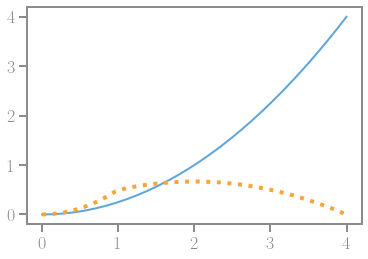

In [69]:
plt.plot(data.load, _F(0, data.load.values))
plt.plot(data.load, data.elastic_energy, ls='dotted', lw=4)

In [70]:

matpar = {k: _k, w1: _w1, N: _N, μ: _mu}


{k: 4, w1: 2, N: 2, μ: 1}

In [120]:
_tc = sp.solve(Fa, t)[1].subs({α: 0})
_tc
__tc = _tc.subs({k: 3, w1: 1, N: 2, μ: 1})
sp.N(__tc)

IndexError: list index out of range

In [72]:
sp.N(_tc.subs(matpar))

NameError: name '_tc' is not defined

In [ ]:
# params, data, signature = pp.load_data(experiment)

plt.plot(data.load, data.fracture_energy, label = 'damage')
plt.plot(data.load, data.elastic_energy, label = 'elastic')
_total = data.fracture_energy + data.elastic_energy
plt.plot(data.load, _total, label = 'total')
# plt.axvline(__tc, c='k')
plt.axvline(_tc.subs(matpar), c='k', lw=1)
plt.legend()
plt.xlabel('load')
plt.ylabel('Energy')

plt.plot(data.load, _F(0, data.load.values), ls = 'dotted')
# plt.plot(data.load, 2*Ef(0, data.load.values), ls = 'dotted')


plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.title(f'N={_N}, k={_k}')



In [121]:
## Simple Analytic 
α, α1, α2, e1, e2 = sp.symbols('α α1 α2 e1 e2')
w1 = sp.symbols('w1', positive=True)
τ = sp.Symbol('τ', positive=True)
k = sp.Symbol('k', positive=True)

# _N = 2

Ηeye = lambda τ: w1*(k-1)/(k-τ)*(k-2*τ)/τ
Ηout = lambda τ: w1*(k-1)/(k-τ)*k/τ

matpar = {k: _k, w1: _w1, N: _N, μ: _mu}

_Ηeye = N**2*w1*(k-1)/(k-τ)*(k-2*τ)/τ
_Ηout = w1*(k-1)/(k-τ)*k/τ

# _Ηeye = sp.lambdify(τ, _Ηeye.subs(matpar), 'numpy')
# _Ηeye(0)


In [122]:
# _Ηeye
Ηeye = sp.lambdify(τ, _Ηeye.subs(matpar), 'numpy')
Ηout = sp.lambdify(τ, _Ηout.subs(matpar), 'numpy')


<lambdifygenerated-8>:2: RuntimeWarning: divide by zero encountered in true_divide
  return 24*(4 - 2*τ)/(τ*(4 - τ))
<lambdifygenerated-9>:2: RuntimeWarning: divide by zero encountered in true_divide
  return 24/(τ*(4 - τ))


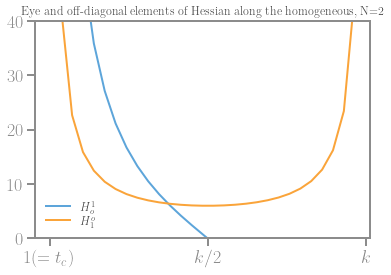

In [123]:
τs = np.linspace(0.01, matpar[k], 30)
plt.plot(τs, Ηeye(τs), label='$H_o^1$')
plt.plot(τs, Ηout(τs), label='$H^o_1$')

# for n in range(2, 3):
    # plt.plot(τs, 4*Ηeye(τs)/n**2, label=f'$H_o^{n}$')
    # plt.plot(τs, 4*Ηout(τs)/n**2, label=f'$H^o_{n}$')

plt.ylim(0, 40)

# plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.xticks([0, _k/2, _k], ['$1 (=t_c)$', '$k/2$','$k$'])
plt.title("Eye and off-diagonal elements of Hessian along the homogeneous, N=2")
plt.legend()

In [ ]:
A, B = sp.symbols('A B')
H = sp.Matrix([[A-B, A],
           [A, A-B]])


In [124]:
def _critical_load(matpar):
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
    return np.sqrt(8*_w1 / (_mu*_k)/4)
    # independent of _N**2

def a_atk(alpha):
    return (1 - alpha) / ((_k-1) * alpha + 1)

def s_atk(alpha):
    return 1/a_atk(alpha)

def _homogeneous_state(t, matpar):
    """docstring for _homogeneous_state"""
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


    # _tc = np.sqrt(matpar/k)
    # _a = (tau - 1) / (_k - 1)

    _tc = _critical_load(params["model"])
    _uh = [0 for i in range(0, _N+1)]
    
    if t <= _tc:
        # elastic
        _alphah = [0. for i in range(0, _N)]
        _uh = [i*t/_N for i in range(0, _N+1)]
    else:   
        # damaging
        _α = (t/_tc - 1) / (_k - 1)
        _alphah = [_α for i in range(0, _N)]

        # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
        _S = _N*a_atk(_α)

        _e = t / _N
        for i in range(0, _N+1):
            if i == 0:
                _uh[i] = 0
            else: 
                _uh[i] = _e * i
        # _uh = [a_atk(_α) / (_N*a_atk(_α)) * i/_N for i in range(0, _N+1)]
        # print(t, _e)
    return _alphah, _uh

In [125]:
_homogeneous_state(1, params["model"])

([0.0, 0.0], [0.0, 0.5, 1.0])

In [127]:
from functools import reduce

In [128]:
_α = .2
a_atk(_α)
_alphah = [_α for i in range(0, _N)]
_alphah
_S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))

s_atk(_α) / _S


2.0

s

In [129]:
_critical_load(params["model"])

1.0

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_98610/3134143365.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/a_atk(alpha)


(0.0, 3.0)

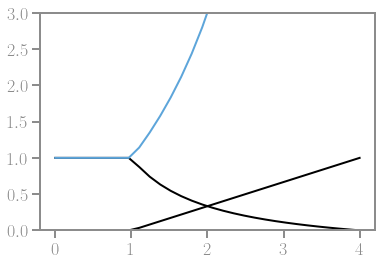

In [141]:
_alphas = [_homogeneous_state(t, params["model"])[0][0] for t in data.load]
plt.plot(data.load, _alphas, c='k')
plt.plot(data.load, [a_atk(a) for a in _alphas], c='k')
plt.plot(data.load, [s_atk(a) for a in _alphas])
# plt.plot(data.load, [s_atk(a)/(_N*s_atk(a)) for a in _alphas])
plt.ylim(0, 3)


(0.0, 4.0)

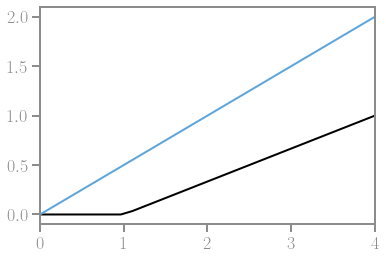

In [143]:
# _homogeneous_state(.1, params["model"])

plt.plot(data.load, [_homogeneous_state(t, params["model"])[0][0] for t in data.load], c='k')
plt.plot(data.load, [_homogeneous_state(t, params["model"])[1][1] for t in data.load])
plt.xlim([0, _tc*_k])
# plt.ylim(0, 10)


## End analysis

In [ ]:
data;

In [ ]:
plt.plot(data.load, data.F, label = 'stress')
# plt.plot(data.load, data.elastic_energy, label = 'elastic')
# _total = data.fracture_energy + data.elastic_energy
# plt.plot(data.load, _total, label = 'total')
plt.legend()
plt.xlabel('load')
plt.ylabel('stress')
# plt.axhline(_σc/2, c='k')

plt.axvline(_tc.subs(matpar), c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.title(f'N={_N}, k={_k}')


In [ ]:
for k in range(model_parameters["N"]):
    plt.plot(data.load, [a[k] for a in data.alpha_t], label=f'$\\alpha_{k}$')

plt.title("$\\alpha$")
plt.legend()
plt.axhline(1, c='k')

plt.axvline(_tc.subs(matpar), c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.title(f'N={_N}, k={_k}')


In [ ]:
for k in range(model_parameters["N"]+1):
    plt.plot(data.load, [u[k] for u in data.u_t], label=f'$u_{k}$')
plt.plot(data.load, 1/_mu*data.load/2, label=f'$u^*$', ls='dotted', lw=4)

plt.legend()
plt.title("$u$")
plt.axhline(data.load.values[-1], c='k')

plt.axvline(_tc.subs(matpar), c='k', lw=1)
plt.axvline(_k, c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.title(f'N={_N}, k={_k}')


In [ ]:
for i in range(len(data.cone_data)):
    plt.plot(data.cone_data[i]['error_x_L2'], label=f'step {i}')
plt.semilogy()
# plt.legend()
plt.xlabel('iterations')
plt.ylabel('$||\Delta x_k||_{L^2}$')


In [ ]:
data.cone_data[3].keys()

In [ ]:
_stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]
_stab_cnd;

In [ ]:
for i in range(len(data.cone_data)):
    plt.plot(data.cone_data[i]['y_norm_L2'], label=f'step {i}')
# plt.semilogy()
# plt.legend()
plt.axhline(0, c='k')
plt.xlabel('iterations')
plt.ylabel('$||y_k||_{L^2}$')


In [ ]:
for i in range(len(data.cone_data)):
    plt.plot(data.cone_data[i]['lambda_k'], label=f'step {i}')
plt.axhline(0, c='k')
plt.title('Convergence of eigenvalues')
plt.xlabel('iterations')


In [ ]:
_asd = np.array([step["lambda_0"] for step in data["cone_data"]])
# [0 if x==3 for x in _asd]
_lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
plt.plot(data.load, _lambda_0, marker='o', ls='')
plt.axhline(0, c='k')
# plt.ylim([0, 1.])
plt.xlim([0, _k])

plt.axvline(_tc.subs(matpar), c='k', lw=1)
plt.axvline(_k, c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
plt.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.5)

plt.title('Minimum eigenvalue and stability')

In [ ]:
plt.scatter(data.load, _lambda_0, c=_stab_cnd, cmap='RdYlGn_r', alpha=.8)
plt.xlim([0, _k])
plt.ylim([-1, 1])
plt.axhline(0, c='k')

plt.title('Stability, minimum K-eigen')

In [ ]:
data;

In [ ]:


# plt.plot(_stab_cnd)
plt.plot(data.load, data.fracture_energy)
plt.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.5)
plt.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)

In [ ]:
plt.plot(data.load, data.F, label = 'stress')
plt.fill_between(data.load, 0, .1, where=_stab_cnd,color='red', alpha=0.5)
plt.fill_between(data.load, 0, .1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
plt.legend()

plt.axvline(_tc.subs(matpar), c='k', lw=1)
plt.axvline(_k, c='k', lw=1)
plt.axvline(_k/2, c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k/2, _k], ['$t_c$', '$k/2$', '$k$'])
plt.title(f'N={_N}, k={_k}')



In [ ]:
[converged['iterations'] for converged in data.cone_data]
# [converged['lambda_k'] for converged in data.cone_data]

In [ ]:
asd = np.array([converged['lambda_k'][-1] for converged in data.cone_data if isinstance(converged['iterations'], int)])
asd
# plt.plot(asd)

In [ ]:
[converged['lambda_k'][-1] for converged in data.cone_data if len(converged['lambda_k'])>0]

## N=3

Vivo alla base, ho  srotolato solo hardcore / mi alleno co' Alien D: pronto Ensi  per i lividi / . Missione Speciale: FeasterRootsConnect. _Complete_ co' un risultato universale..:

In [ ]:
experiment = '../../practice/output/discrete-atk-N3'
params, data, signature = pp.load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get(
    "w1"), model_parameters.get("k"), model_parameters["N"]

model_parameters

In [ ]:
_stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]
# _stab_cnd
data["cone-stable"];
np.array([step["lambda_0"] for step in data["cone_data"]])

In [ ]:
_postprocess_stability(data)
b

In [ ]:
_postprocess_stability2(data)


## N=4

Vivo alla base, ho  srotolato solo hardcore / mi alleno co' Alien D: pronto Ensi  per i lividi / . Missione Speciale: FeasterRootsConnect. _Complete_ co' un risultato universale..:

In [ ]:
experiment = '../../test/output/discrete-atk-N4'
params, data, signature = pp.load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get(
    "w1"), model_parameters.get("k"), model_parameters["N"]

model_parameters

In [ ]:
_postprocess_stability(data)
_postprocess_stability2(data)



## N=5

In [372]:
experiment = '../../test/output/discrete-atk-N5'
params, data, signature = pp.load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get(
    "w1"), model_parameters.get("k"), model_parameters["N"]

model_parameters

{'N': 5,
 'ell': 0.1,
 'k': 4,
 'k_res': 0,
 'model_dimension': 1,
 'model_type': '1D',
 'mu': 1,
 'w1': 2}

In [ ]:
_postprocess_stability(data)
_postprocess_stability2(data)



## Parametric

In [ ]:
for _n in np.arange(2, 6):
    print(_n)
    experiment = f'../../test/output/discrete-atk-N{_n}'
    params, data, signature = pp.load_data(experiment)
    model_parameters = params.get("model")

    _mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get(
        "w1"), model_parameters.get("k"), model_parameters["N"]
    _postprocess_stability(data)
    _postprocess_stability2(data)




/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_98610/1708371343.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])


<AxesSubplot:title={'center':'Inf of the K-spectrum and stability'}>

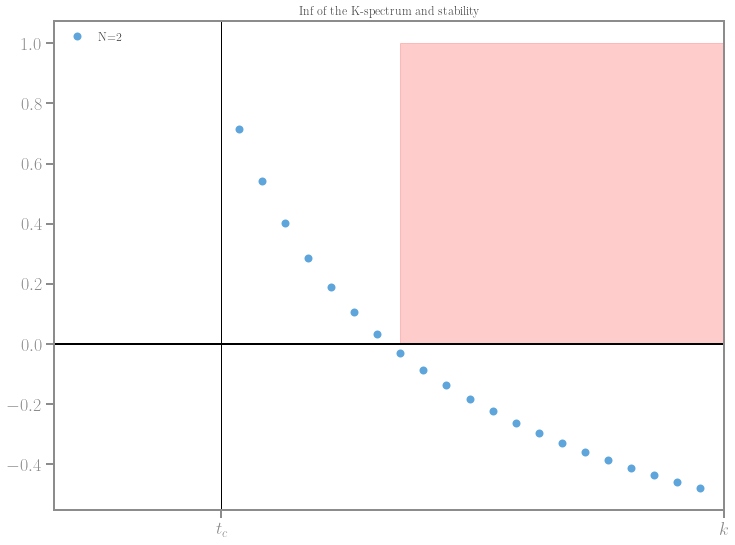

In [32]:
experiment = f'../../test/output/discrete-atk-N2'
params, data, signature = pp.load_data(experiment)

_mu, _w1, _k, _N = params["model"].get("mu"), params["model"].get(
        "w1"), params["model"].get("k"), params["model"]["N"]

# _tc = _critical_load(params["model"])
# print(_tc)
_plot_min_sigmaKappa(data, params = params["model"])


In [38]:
_k

4

2
3
4
5


/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_98610/1708371343.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_98610/1708371343.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_98610/1708371343.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

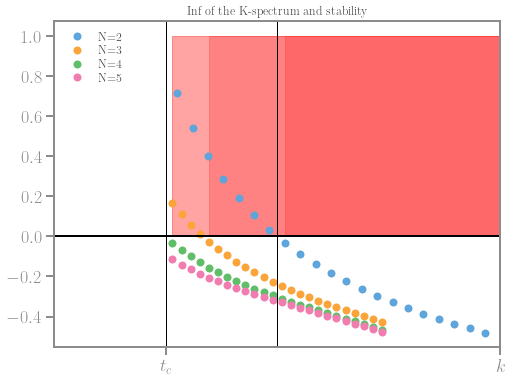

In [37]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

for _n in np.arange(2, 6):
    print(_n)

    experiment = f'../../test/output/discrete-atk-N{_n}'
    params, data, signature = pp.load_data(experiment)
    # model_parameters = params.get("model")
    _tc = _critical_load(params["model"])
    # print(_tc)
    _mu, _w1, _k, _N = params["model"].get("mu"), params["model"].get(
        "w1"), params["model"].get("k"), params["model"]["N"]
    axis = _plot_min_sigmaKappa(data, axis, params["model"])
    # plt.axvline(_k/_N, c='k', ls='dotted', lw=1)
    # _postprocess_stability2(data)
plt.axvline(_tc*_k/2, c='k', lw=1)

# figure.savefig('../../notes/figures/stability_vary_N.png')


## Verification of homogenous

In [130]:

experiment = f'../../practice/output/discrete-atk-N2-homogeneous'
params, data, signature = pp.load_data(experiment)
_mu, _w1, _k, _N = params["model"].get("mu"), params["model"].get(
        "w1"), params["model"].get("k"), params["model"]["N"]

matpar = {k: _k, w1: _w1, N: _N, μ: _mu}


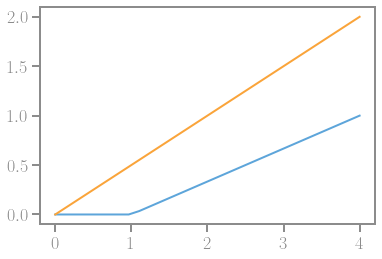

In [131]:
plt.plot(data.load, [a[0] for a in data.alpha_t])
plt.plot(data.load, [u[_N-1] for u in data.u_t])

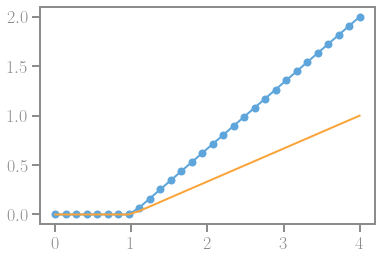

In [132]:
plt.plot(data.load, data.fracture_energy, label = 'damage', marker='o')
plt.plot(data.load, [a[0] for a in data.alpha_t])


In [6]:


# plt.plot(data.load, data.fracture_energy)
# plt.fill_between(data.load, 0, 1, where=_stab_cnd(data),color='red', alpha=0.5)
# plt.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd(data)], color='green', alpha=0.5)


plt.plot(data.load, data.fracture_energy, label = 'damage', marker='o')
plt.plot(data.load, data.elastic_energy, label = 'elastic')
_total = data.fracture_energy + data.elastic_energy
plt.plot(data.load, _total, label = 'total')
# plt.axvline(__tc, c='k')
plt.axvline(_tc, c='k', lw=1)
plt.legend()
plt.xlabel('load')
plt.ylabel('Energy')


NameError: name 'data' is not defined

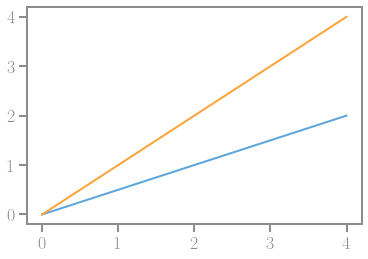

In [134]:
plt.plot(data.load, [u[1] for u in data['u_t']])
plt.plot(data.load, [u[2] for u in data['u_t']])
# plt.plot(data.load, data['u_t'][2])

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_77700/1708371343.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])


NameError: name '_tc' is not defined

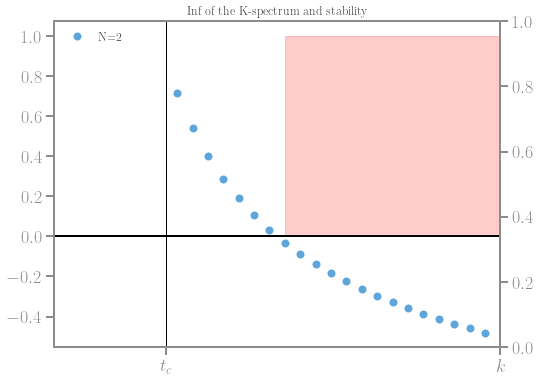

In [137]:
# τs = np.linspace(0.01, matpar[k], 30)

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

# plt.plot(data.load/_tc, 4*Ηeye(data.load/_tc), label='$H_o^1$')
# plt.plot(data.load/_tc, 4*Ηout(data.load/_tc), label='$H^o_1$')
axis = _plot_min_sigmaKappa(data, axis, params["model"])
axis2 = axis.twinx()
axis2.plot(data.load/_tc, Ηeye2(data.load/_tc)/100, label='analytical criterion', c='k')
plt.legend()

plt.axvline(_tc*_k/2, c='k', lw=1)
plt.ylim(-.5, 1)
# figure.savefig('../../notes/figures/stability_N2.png')


verify Nd hessian

In [139]:
α = sp.symbols('α')
t, N, k = sp.symbols('t N k')
τ = sp.Symbol('τ', positive=True)

_α0 = (τ-1)/(k-1)

# Ηeye = lambda τ: w1*(k-1)/(k-τ)*(k-2*τ)/τ
# Ηout = lambda τ: w1*(k-1)/(k-τ)*k/τ

matpar = {k: _k, w1: _w1, N: _N, μ: _mu}

_Ηeye2 = N**2*w1*(k-1)/(k-τ)*(k-2*τ)/τ
_Ηout2 = N**2*w1*(k-1)/(k-τ)*k/τ

# _Ηeye
Ηeye2 = sp.lambdify(τ, _Ηeye2.subs(matpar), 'numpy')
Ηout2 = sp.lambdify(τ, _Ηout2.subs(matpar), 'numpy')


_ΗeyeN = t**2/(N*s(α))**2 * ((s(α).diff(α))**2 / (N*s(α)) - 1./2.*s(α).diff(α, 2)) 
_ΗoutN = t**2*(s(α).diff(α))**2 / (N*s(α))**3


In [140]:
_Ηeye2

N**2*w1*(k - 1)*(k - 2*τ)/(τ*(k - τ))

In [143]:
_ΗeyeN.subs({α: _α0}).simplify()

1.0*k*t**2*(-N*k*τ + N*τ + k**2 - k)/(N**3*τ**3*(k - τ))

In [144]:
sp.latex(_ΗeyeN.subs({α: _α0}).simplify())

'\\frac{1.0 k t^{2} \\left(- N k τ + N τ + k^{2} - k\\right)}{N^{3} τ^{3} \\left(k - τ\\right)}'

In [145]:
sp.factor(_ΗeyeN.subs({α: _α0}))

k*t**2*(1.0*k - 1.0)*(1.0*k - 1.0*τ)**3*(-1.0*N*τ + 1.0*k)/(N**3*τ**3*(k - τ)**4)

In [146]:
sp.latex(sp.factor(_ΗeyeN.subs({α: _α0})))

'\\frac{k t^{2} \\cdot \\left(1.0 k - 1.0\\right) \\left(1.0 k - 1.0 τ\\right)^{3} \\left(- 1.0 N τ + 1.0 k\\right)}{N^{3} τ^{3} \\left(k - τ\\right)^{4}}'

In [150]:
sp.factor(_ΗeyeN.subs({α: _α0}).subs({t: τ}))

k*(1.0*k - 1.0)*(1.0*k - 1.0*τ)**3*(-1.0*N*τ + 1.0*k)/(N**3*τ*(k - τ)**4)

In [151]:
sp.latex(sp.factor(_ΗeyeN.subs({α: _α0}).subs({t: τ})))

'\\frac{k \\left(1.0 k - 1.0\\right) \\left(1.0 k - 1.0 τ\\right)^{3} \\left(- 1.0 N τ + 1.0 k\\right)}{N^{3} τ \\left(k - τ\\right)^{4}}'

In [153]:
sp.solve(_ΗeyeN.subs({α: _α0}).subs({t: τ}), τ)

[k/N]

In [242]:
_ΗeyeN.subs({α: _α0, N: 2}).subs(matpar)


t**2*(4/3 - τ/3)**2*(-1.0*(-τ/(τ/3 - 4/3) + 3)/(τ/3 - 4/3)**2 + (4/3 - τ/3)*(τ/(4/3 - τ/3)**2 + 3/(4/3 - τ/3))**2/(2*τ))/(4*τ**2)

In [258]:
matpar

{k: 4, w1: 2, N: 2, μ: 1}

In [286]:
_k

4

In [289]:
ΗeyeN = sp.lambdify((τ, N), _ΗeyeN.subs({α: _α0, t:1}).subs({k: _k}), 'numpy')
ΗeyeN(3, 2)

-0.1111111111111111

In [259]:


ΗeyeN = sp.lambdify(τ, _ΗeyeN.subs({α: _α0, t:1}).subs(matpar), 'numpy')
# ΗeyeN(3)
# plt.plot(data.load, HeyeN(data.load))
# ΗeyeN(1)


In [1]:
_Ηeye2

NameError: name '_Ηeye2' is not defined

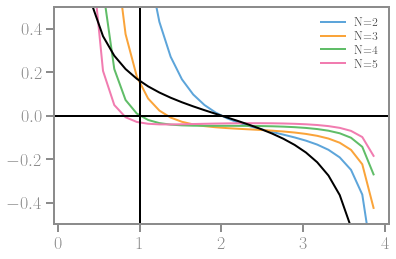

In [301]:
for _n in np.arange(2, 6):
    plt.plot(data.load, ΗeyeN(data.load, _n), label=f'N={_n}')
# ΗeyeN(3, 2)

plt.plot(data.load, Ηeye2(data.load)/100, c='k')
plt.ylim(-.5, .5)
plt.axvline(_tc, c='k')
plt.axhline(0, c='k')
plt.legend()

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_98610/1708371343.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_98610/1708371343.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_98610/1708371343.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is 

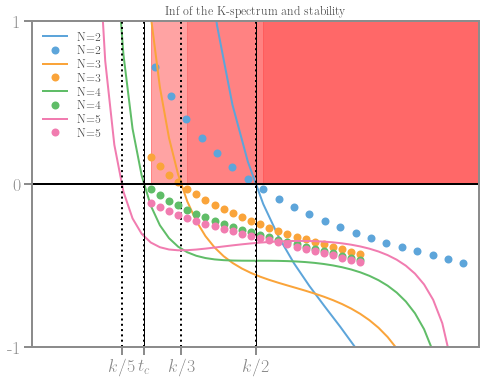

In [321]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

for _n in np.arange(2, 6):
    experiment = f'../../test/output/discrete-atk-N{_n}'
    params, data, signature = pp.load_data(experiment)
    # model_parameters = params.get("model")
    plt.plot(data.load, 10*ΗeyeN(data.load, _n), label=f'N={_n}', c=f'C{_n-2}')
    _tc = _critical_load(params["model"])
    # print(_tc)
    _mu, _w1, _k, _N = params["model"].get("mu"), params["model"].get(
        "w1"), params["model"].get("k"), params["model"]["N"]
    axis = _plot_min_sigmaKappa(data, axis, params["model"])
    plt.axvline(_k/_N, c='k', ls='dotted')
    
plt.axvline(_tc*_k/2, c='k', lw=1)
plt.ylim(-1, 1)
axis.set_yticks([-1, 0, 1], ['-1', '0', '1'])
axis.set_xticks([_tc, _k/2, _k/3, _k/5], ['$t_c$',  '$k/2$', '$k/3$',  '$k/5$'])

# figure.savefig('../../notes/figures/stability_vary_N.png')


In [310]:
_ΗeyeN.subs({α: _α0, t:1}).simplify()

1.0*k*(-N*k*τ + N*τ + k**2 - k)/(N**3*τ**3*(k - τ))

In [311]:
__eye = _ΗeyeN.subs({α: _α0, t:1}).simplify()

In [353]:
asd = [_k/N for N in _Ns]
_filter = np.where(np.array(asd) > _tc)[0]


In [361]:
[_k/N if _k/N>=_tc else _tc for N in _Ns ]

[2.0, 1.3333333333333333, 1.0, 1.0, 1.0]

Text(0, 0.5, '$\\delta_s$')

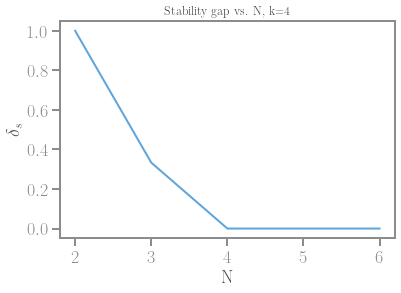

In [371]:
_gap = sp.solve(__eye, τ)[0]

_gap.subs({k: _k})
_Ns = np.arange(2, 7)
plt.plot(_Ns, [_k/N - _tc if _k/N>=_tc else 0 for N in _Ns ])
plt.title(f'Stability gap vs. N, k={_k}')
plt.xlabel("N")
plt.ylabel("$\delta_s$")


## Test NLB

In [380]:
experiment = '../../test/output/test_NLB'
params, data, signature = pp.load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get(
    "w1"), model_parameters.get("k"), model_parameters["N"]

model_parameters

{'N': 3,
 'ell': 0.1,
 'k': 4,
 'k_res': 0.0001,
 'model_dimension': 1,
 'model_type': '1D',
 'mu': 1,
 'w1': 2}

(0.0, 4.0)

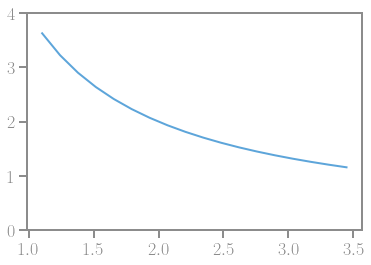

In [382]:
plt.plot(data.load, data["Hii"])
plt.ylim(0, 4)

## Stability of an AT1 bar

$$
E(u):=\frac{1}{2} \int_0^1 a(\alpha)u'^2 dx + w_1 \int_0^1 w(\alpha) + \ell^2 (\alpha')^2 dx
$$

$$
w(\alpha):= \alpha, \qquad a(\alpha):= (1-\alpha)^2 =: a_{AT_1}
$$

In [34]:
## Simple Analytic 
α = sp.symbols('α')
u = sp.symbols('u')
# s1, s2 = sp.symbols('s1 s2', positive=True)
# μ, N = sp.symbols('μ N', positive=True)
w1 = sp.symbols('w1', positive=True)
t = sp.Symbol('t', positive=True)

aAT1 = lambda α: (1-α)**2
s = lambda α: 1/aAT1(α)

# U = 1/2*μ*(K1*u1**2 + K2*(t-u1)**2)
# S = w1*(α1 + α2) / N**2
def _critical_load(params):
    return 1.
# sol_u = sp.solve(U.diff(u1), u1)



In [158]:
_lambda_0

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.00037819087620018644,
 0.0003395535213731991,
 0.0003357573613913637,
 0.00036349878357818934,
 0.0003280640518862549,
 0.00032416009485085887]

In [171]:
# data["uniqueness"]



/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_16045/747235365.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])


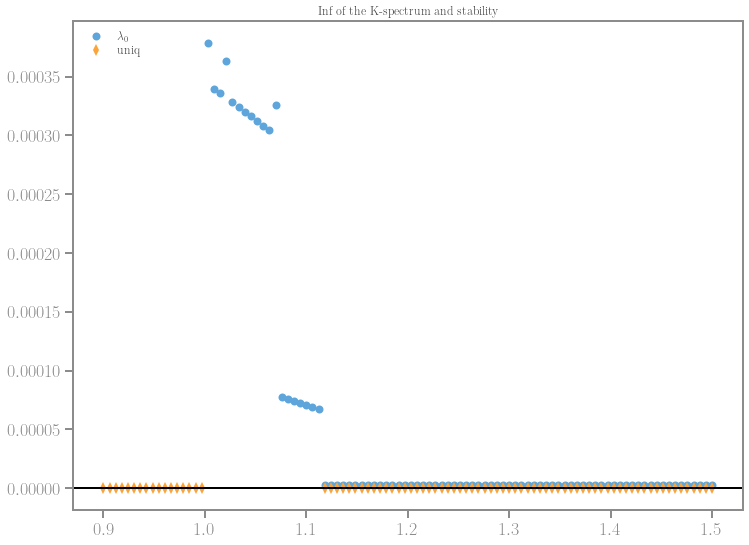

In [172]:
figure, axis = plt.subplots(1, 1, figsize=(12, 9))
_asd = np.array([step["lambda_0"] for step in data["cone_data"]])
_lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
# _lambda_0
axis.plot(data.load, _lambda_0, marker='o', ls='', label=f"$\lambda_0$")
# ax2 = .twinx()
axis.plot(data.load, _uni, marker='d', ls='', label=f"uniq")
# [0 if x==3 for x in _asd]
axis.axhline(0, c='k')
# axis.set_ylim([0, max(_lambda_0)])
# axis.set_xlim([0, _k])

# axis.axvline(_tc, c='k', lw=1)
# axis.axvline(_tc.subs(_params), c='k', lw=1)
# axis.axvline(_k, c='k', lw=1)

# axis.set_xticks([_tc, _k], ['$t_c$', '$k$'])
# axis.set_xticks([_tc.subs(_params), _k], ['$t_c$', '$k$'])
# axis.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.2)
# axis.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.2)
axis.set_title('Inf of the K-spectrum and stability')

axis.legend(loc=2)


### Traction AT1

In [169]:
experiment = '../../practice/output/traction_AT1_cone'
# experiment = '../../practice/output/traction_AT1_cone-zoom'
params, data, signature = pp.load_data(experiment)


In [96]:
    _ts = np.where(np.abs(np.diff(_lambda_0))>.0001)[0][0]
data.load[_ts]

1.0655172413793104

In [185]:

def plot_energy_spectrum(_data, inset_xbounds=[.5, 1.1]):
    """docstring for plot_energy_spectrum"""

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))
    
    _asd = np.array([step["lambda_0"] for step in _data["cone_data"]])
    _lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
    _uni = [0 if d==True else np.nan for d in data["uniqueness"]]

    axis.plot(_data.load, _data.fracture_energy, lw=7, label = 'damage', marker='o')
    axis.plot(_data.load, _data.elastic_energy, lw=7, label = 'elastic')
    _total = _data.fracture_energy + _data.elastic_energy
    axis.plot(_data.load, _total, lw=5, label = 'total', zorder=.1)
    # plt.axvline(__tc, c='k')
    # plt.axvline(_tc, c='k', lw=1)
    axis.legend()
    axis.set_xlabel('load', fontsize=24, color='k')
    axis.set_ylabel('Energy', fontsize=24, color='k')
    plt.tight_layout()

    _ax = plt.gca()

    zax = inset_axes(_ax,  width='40%', height='40%', loc=3,
        bbox_to_anchor=(.1+.4,1-.6,1,1), bbox_transform=_ax.transAxes)
    # plot again (PLOT AGAIN) the same stuff as before in the new axes
    zax.plot(_data.load, _lambda_0, marker="o", alpha = .7, ls='', ms=10)
    zax.plot(data.load, _uni, marker='d', ls='', label=f"unique")
    _tol = .0001
    zax.axhline(0, c='grey')
    zax.axhline(_tol, c='grey', lw=5, alpha=.5)
    zax.set_title('K-spectrum')

    zax.set_xlim((inset_xbounds[0], inset_xbounds[1])) ; 
    # _ts_i = np.where(np.array(_lambda_0) < 0)[0][0]
    _tr = np.where(np.abs(np.diff(_data.elastic_energy))>.02)
    _tr = np.where(np.abs(np.diff(_data.elastic_energy))>.02)
    _ts_i = np.where(np.abs(np.diff(_lambda_0))>.0001)[0][0]
    _ts = _data.load[_ts_i]

    rectpatch, connects= _ax.indicate_inset_zoom(zax, lw=2, ec='none', alpha=.7, capstyle='butt', edgecolor='grey')
    zax.set_facecolor((1.0, 1., 1.))

    connects[0].set_visible(True)
    connects[1].set_visible(False)
    connects[2].set_visible(True)
    connects[3].set_visible(True)

    _ax.set_xticks([0., _data.load[0], _data.load[_tr[0]].values[0], 1, _ts], ["$$0$$", "$$t_i$$", "$$t_?$$", "1", "$$t_s$$"])
    # _ax.set_xticks([0., _data.load[_tr[0]].values[0], 1, _ts], ["$$0=t_c$$", "$$t_?$$", "1", "$$t_s$$"])
    zax.set_xticks([1, _ts], ["$$1$$", "$$t_s$$"])
    zax.set_yticks([0, _tol], ["$$0$$", "tol"])
    _ax.set_yticks([0], ["$$0$$"])
    _ax.set_title("Evolution of a brittle bar with an elastic phase")
    _ax.set_xlim((_data.load[0], _data.load.to_list()[-1])) ; 

    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)

    return figure, (_ax, zax)



/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_16045/3707918833.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in _data["cone_data"]])


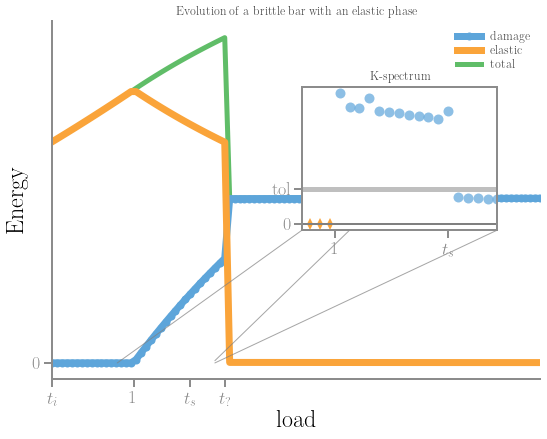

In [186]:
fig, _ = plot_energy_spectrum(data,  inset_xbounds=[.98, 1.1])

In [233]:

plt.tight_layout()
fig.savefig('../../notes/figures/energy-stability_bar-AT1.pdf')

<Figure size 432x288 with 0 Axes>

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_16045/3707918833.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in _data["cone_data"]])
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_16045/253971531.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in _data["cone_data"]])
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_16045/176790070.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so 

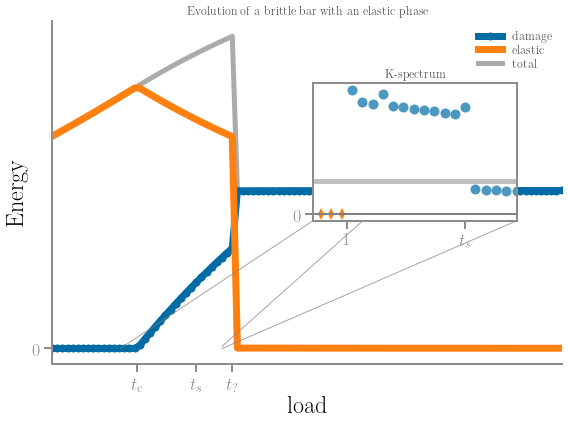

In [234]:
with plt.style.context('tableau-colorblind10'):
    _fig, (_ax, _zax) = plot_energy_spectrum(data, inset_xbounds=[.98, 1.1])


_lambda_0 = _inf_Kspectrum(data)

_ts = get_stability_load(_lambda_0, data)
_tr = get_crack_load(data)

_ax.set_xticks([0., data.load[_tr[0]].values[0], 1, _ts], ["$$0$$", "$$t_?$$", "$$t_c$$", "$$t_s$$"])
_zax.set_xticks([1, _ts], ["$$1$$", "$$t_s$$"])
_zax.set_yticks([0], ["$$0$$"])

_ax.set_yticks([0], ["$$0$$"])
_ax.set_title("Evolution of a brittle bar with an elastic phase")
_ax.set_xlim((data.load[0], data.load.to_list()[-1])) ; 

plt.tight_layout()
# _fig.savefig('../../notes/figures/energy-stability_bar-AT1.png')


In [238]:
_fig.savefig('../../notes/figures/energy-stability_bar-AT1.png')
# 

$$
s:= t + \int_0^t ||\dot \alpha||_{1, 2} dx
$$

In [191]:
sell = []
s0 = []
_dt = (params.get("loading").get("max") - params.get("loading").get("min")) /params.get("loading").get("steps")

for i, t in enumerate(data.get("load")):
    sell.append(np.trapz(data.get("rate_12_norm")[0:i], data.get("load")[0:i])/_dt)

for i, t in enumerate(data.get("load")):
    s0.append(np.trapz(data.get("unscaled_rate_12_norm")[0:i], data.get("load")[0:i])/_dt)
    
# s = data.get("load") + s0

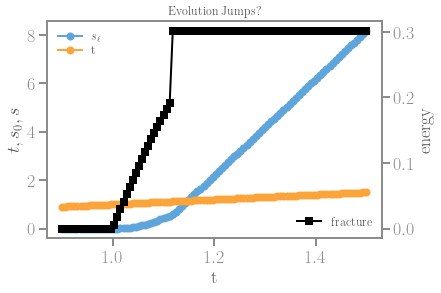

In [193]:
plt.title("Evolution Jumps?")
# plt.plot(data.get("load"), s, marker = 'o', label='s')
plt.plot(data.get("load"), sell, marker = 'o', label='$s_\ell$')
# plt.plot(data.get("load"), s0, marker = 'o', label='$s_0$')
plt.plot(data.get("load"), data.get("load"), marker = 'o', label='t')
plt.ylabel('$t, s_0, s$')
plt.xlabel('t')
plt.legend()
plt.twinx()
plt.plot(data.get("load"), data.get("fracture_energy")/params.get("geometry").get("Ly"),
    marker = 's', c='k', label='fracture')
plt.ylabel('energy')
plt.legend(loc=4)
# plt.savefig('jumps_evo_multifiss.png')

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_22585/746436038.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])


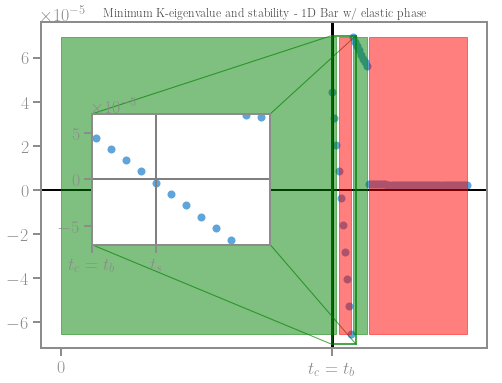

In [155]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))
# _ax = axis[0]
_ax = axis

_asd = np.array([step["lambda_0"] for step in data["cone_data"]])
_lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
_stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]

_ax.plot(data.load, _lambda_0, marker='o', ls='')
_ax.axhline(0, c='k')
_ax2 = _ax.twinx()

_ax2.fill_between(data.load, 0, .001, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
_ax2.fill_between(data.load, 0, .001, where=_stab_cnd,color='red', alpha=0.5)
_ax.set_title('Minimum K-eigenvalue and stability - 1D Bar w/ elastic phase')
_ax.axvline(1., c='k', lw=3)
_ax2.set_yticks([])
# _ax = axis[1]

# for i in range(len(data.cone_data)):
#     _ax.plot(data.cone_data[i]['error_x_L2'], label=f'step {i}')
# _ax.semilogy()
# # _ax.legend()
# _ax.set_xlabel('iterations')
# _ax.set_ylabel('$||\Delta x_k||_{L^2}$')
# zax = zoomed_inset_axes(_ax, .4, loc=1)
zax = inset_axes(_ax,  width='40%', height='40%', loc=3,
    bbox_to_anchor=(.1,1-.7,1,1), bbox_transform=_ax.transAxes)
# plot again (PLOT AGAIN) the same stuff as before in the new axes
zax.plot(data.load, _lambda_0, marker='o', ls='')
zax.axhline(0, c='grey')
# _zax2 = zax.twinx()

# _zax2.fill_between(data.load, 0, .001, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
# _zax2.fill_between(data.load, 0, .001, where=_stab_cnd,color='red', alpha=0.5)
# _zax2.set_yticks([])



# and eventually specify the x, y limits for the zoomed plot,
# as well as the tick positions
zax.set_xlim((1., 1.09)) ; 
_ts_i = np.where(np.array(_lambda_0) < 0)[0][0]
_ts = data.load[_ts_i]

_ax.set_xticks([0., 1.], ["$$0$$","$$t_c=t_b$$"])
zax.set_xticks([1., _ts], ["$$t_c=t_b$$", "$$t_s$$"])
zax.axvline(_ts, c='grey')
zax.set_ylim((-7e-5, 7e-5)) ; 
# zax.set_yticks([1]+[-i*0.5 for i in range(12)]) ;
rectpatch, connects= _ax.indicate_inset_zoom(zax, lw=2, ec='g', alpha=.7, capstyle='butt', edgecolor='g')
zax.set_facecolor((1.0, 1., 1.))

connects[0].set_visible(True)
connects[1].set_visible(True)
connects[2].set_visible(True)
connects[3].set_visible(True)

figure.savefig('../../notes/figures/spectrum-stability_bar-AT1.png')


In [222]:
type(data["cone-eig"][0])

list

In [224]:
data["cone-eig"] = data["cone-eig"].apply(lambda y: np.nan if isinstance(y, list) else y)

In [226]:
_stab_cnd = lambda data: [0 if (data["cone-eig"][i] < 0.0001) else 1 for i in range(len(data))]
_stab_cnd(data)
# data["cone-eig"]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

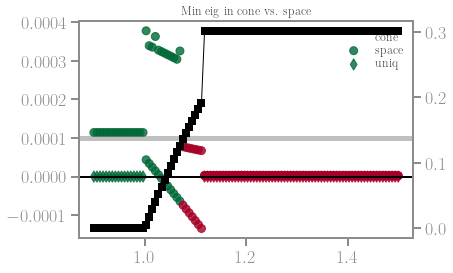

In [237]:
# _stab_cnd = lambda data: [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]
_stab_cnd = lambda data: [1 if (data["cone-eig"][i] < 0.0001) else 0 for i in range(len(data))]

"""docstring for plotSpaceVsCone"""
figure, axis = plt.subplots(1, 1)
__lambda_0 = [e[0] for e in data['eigs']]

axis.scatter(data.load, _lambda_0, c=_stab_cnd(data), cmap='RdYlGn_r', alpha=.8, label='cone')
axis.scatter(data.load, __lambda_0, c=_stab_cnd(data), cmap='RdYlGn_r', alpha=.8, label='space')
axis.scatter(data.load, _uni, c=_stab_cnd(data), cmap='RdYlGn_r', alpha=.8, marker = 'd', label='uniq')
ax2 = axis.twinx()
ax2.plot(data.get("load"), data.get("fracture_energy")/params.get("geometry").get("Ly"),
    marker = 's', c='k', label='fracture', lw=1)

axis.axhline(1e-4, c='gray', alpha=.5, lw=5)
axis.axhline(0., c='k')
axis.set_title('Min eig in cone vs. space')
axis.legend()

In [309]:
experiment = '../../practice/output/traction_AT2_cone'
params, data, signature = pp.load_data(experiment)


In [217]:
_dt = (params.get("loading").get("max") - params.get("loading").get("min")) /params.get("loading").get("steps")

sell = []
for i, t in enumerate(data.get("load")):
    sell.append(np.trapz(data.get("rate_12_norm")[0:i], data.get("load")[0:i])/_dt)

s0 = []
for i, t in enumerate(data.get("load")):
    s0.append(np.trapz(data.get("unscaled_rate_12_norm")[0:i], data.get("load")[0:i])/_dt)
    
# s = data.get("load") + s0

_asd = np.array([step["lambda_0"] for step in data["cone_data"]])
_lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
_stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]



/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_22585/3611149770.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])


In [220]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


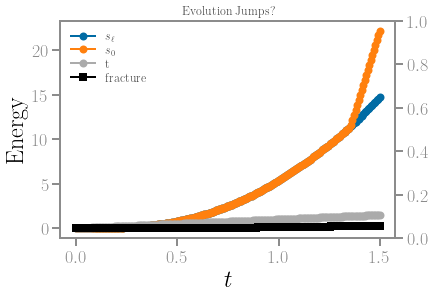

In [243]:


# for i, style in enumerate(plt.style.available):
with plt.style.context('tableau-colorblind10'):
    figure, axis = plt.subplots(1, 1)
    # , figsize=(9, 9)
    axis.set_title("Evolution Jumps?")
    # plt.plot(data.get("load"), s, marker = 'o', label='s')
    axis.plot(data.get("load"), sell, marker = 'o', label='$s_\ell$')
    axis.plot(data.get("load"), s0, marker = 'o', label='$s_0$')
    axis.plot(data.get("load"), data.get("load"), marker = 'o', label='t')
    axis.set_ylabel('$t, s_0, s$', fontsize=24, color='k')
    axis.set_xlabel('$t$', fontsize=24, color='k')
    axis.legend()
    axis.twinx()
    axis.plot(data.get("load"), data.get("fracture_energy")/params.get("geometry").get("Ly"),
        marker = 's', c='k', label='fracture')
    axis.set_ylabel('Energy')
    axis.legend(loc=2)
plt.show()
# plt.savefig(f'jumps_evo_multifiss-style-{style}-{i}.png')


/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_22585/3579149260.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in _data["cone_data"]])
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_22585/3171659484.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in _data["cone_data"]])
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_22585/203835035.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so

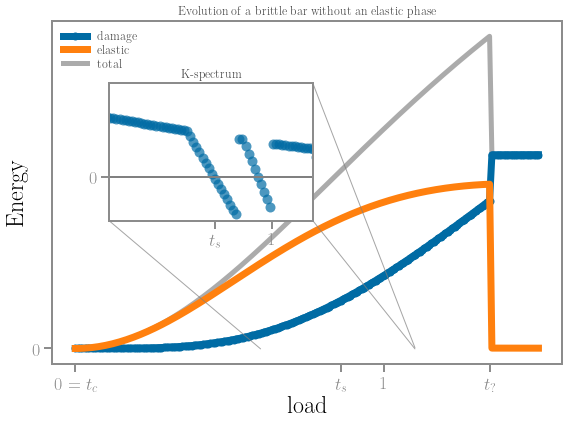

In [312]:
with plt.style.context('tableau-colorblind10'):
    _fig, (_ax, _zax) = plot_energy_spectrum(data, inset_xbounds=[0.6, 1.1])


_lambda_0 = _inf_Kspectrum(data)

_ts = get_stability_load(_lambda_0)
_tr = get_crack_load(data)

# _ax.set_xticks([0., data.load[_tr[0]].values[0], 1, _ts], ["$$0$$", "$$t_?$$", "$$t_c$$", "$$t_s$$"])
# _zax.set_xticks([1, _ts], ["$$1$$", "$$t_s$$"])
# _zax.set_yticks([0], ["$$0$$"])

# _ax.set_yticks([0], ["$$0$$"])
_ax.set_title("Evolution of a brittle bar without an elastic phase")

plt.tight_layout()
_fig.savefig('../../notes/figures/energy-stability_bar-AT2.png')

In [193]:
data.load[_tr[0]].values[0]

1.3417085427135678

In [186]:
_tr = np.where(np.abs(np.diff(data.elastic_energy))>.02)
data.load[_tr[0]]

178    1.341709
Name: load, dtype: float64

In [ ]:

    """docstring for _postprocess_stability"""
    figure, axis = plt.subplots(2, 2, figsize=(12, 9))
    
    _asd = np.array([step["lambda_0"] for step in data["cone_data"]])
    _lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
    _stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]

    _ax = axis[0, 0]
    
    for i in range(len(data.cone_data)):
        _ax.plot(data.cone_data[i]['error_x_L2'], label=f'step {i}')
    _ax.semilogy()
    # _ax.legend()
    _ax.set_xlabel('iterations')
    _ax.set_ylabel('$||\Delta x_k||_{L^2}$')

    _ax = axis[0, 1]

    _ax.scatter(data.load, _lambda_0, c=_stab_cnd, cmap='RdYlGn_r', alpha=.8)
    _ax.set_xlim([0, _k])
    _ax.set_ylim([-1, 1])
    _ax.axhline(0, c='k')

    _ax.set_title('Stability, minimum K-eigen')
    _ax.legend()
    _ax.set_xlabel('load')
    _ax.set_ylabel('$min \\sigma_K$')

    _ax = axis[1, 0]
    # [0 if x==3 for x in _asd]
    _ax.plot(data.load, _lambda_0, marker='o', ls='')
    _ax.axhline(0, c='k')
    # _ax.ylim([0, 1.])
    _ax.set_xlim([0, _k])

    _ax.axvline(_tc.subs(matpar), c='k', lw=1)
    _ax.axvline(_k, c='k', lw=1)

    _ax.set_xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
    _ax.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
    _ax.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.5)
    _ax.set_title('Minimum eigenvalue and stability')

    _ax.legend()

    _ax = axis[1, 1]
    _ax.plot(data.load, data.F, label = 'stress')
    _ax.fill_between(data.load, 0, .1, where=_stab_cnd,color='red', alpha=0.5)
    _ax.fill_between(data.load, 0, .1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
    _ax.legend()

    _ax.axvline(_tc.subs(matpar), c='k', lw=1)
    _ax.axvline(_k, c='k', lw=1)
    _ax.axvline(_k/2, c='k', lw=1)

    _ax.set_xticks([_tc.subs(matpar), _k/2, _k], ['$t_c$', '$k/2$', '$k$'])
    _ax.set_title(f'N={_N}, k={_k}')


    for _ax in axis.reshape(-1):
        _ax.axvline(_tc.subs(matpar), c='k', lw=1)

    plt.show()

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_77700/836895863.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])


Text(0, 0.5, '$||\\Delta x_k||_{L^2}$')

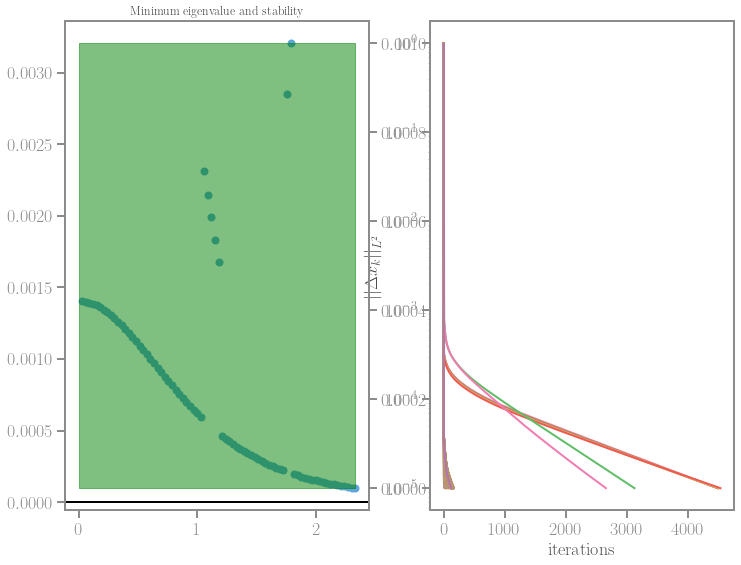

In [239]:
figure, axis = plt.subplots(1, 2, figsize=(12, 9))
_ax = axis[0]

_asd = np.array([step["lambda_0"] for step in data["cone_data"]])
_lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
_stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]

_ax.plot(data.load, _lambda_0, marker='o', ls='')
_ax.axhline(0, c='k')
_ax2 = _ax.twinx()

_ax2.fill_between(data.load, 0, .001, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
_ax2.fill_between(data.load, 0, .001, where=_stab_cnd,color='red', alpha=0.5)
_ax.set_title('Minimum eigenvalue and stability')

_ax = axis[1]

for i in range(len(data.cone_data)):
    _ax.plot(data.cone_data[i]['error_x_L2'], label=f'step {i}')
_ax.semilogy()
# _ax.legend()
_ax.set_xlabel('iterations')
_ax.set_ylabel('$||\Delta x_k||_{L^2}$')


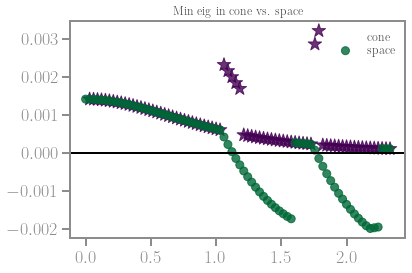

In [274]:
plotSpaceVsCone(data)